<a href="https://colab.research.google.com/github/ITAM-DS/deep-learning/blob/master/codigo/08-LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# !pip install -U d2l
from d2l import tensorflow as d2l
import tensorflow as tf
import numpy as np

# LeNet: La primera CNN con éxito

Usemos `Keras` para implementar el modelo. 

In [10]:
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])

Evaluaremos hacia adelante para tener una idea de las dimensiones necesarias en cada capa del modelo. Usaremos una imagen ficticia de las dimensiones adecuadas. Es decir, una imagen $X \in \mathbb{R}^{28 \times 28}.$ El modelo necesita una imagen en escala de grises (el último `1`) y también recibe una colección de posibles muestras de entrenamiento/validación (el primer `1`).

In [11]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2D output shape: 	 (1, 28, 28, 6)
AveragePooling2D output shape: 	 (1, 14, 14, 6)
Conv2D output shape: 	 (1, 10, 10, 16)
AveragePooling2D output shape: 	 (1, 5, 5, 16)
Flatten output shape: 	 (1, 400)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


Usaremos la *API* del libro para sintetizar los conceptos que hemos visto hasta ahora. Primero descargamos los datos.

In [12]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

## Entrenamiento

Entrenaremos el modelo utilizando el código que incluye nuestra referencia base. Lo interesante del código es que está pensado para utilizar **GPU**s. La estrategia de cómputo es interesante, aunque escapa a los alcances del curso. Para más información sobre la carga de cómputo revisa la [sección correspondiente.](https://d2l.ai/chapter_deep-learning-computation/use-gpu.html) 

Observa que la función de entrenamiento es muy parecida a la función que habíamos utilizado antes. 

In [13]:
class TrainCallback(tf.keras.callbacks.Callback):  
    """A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[1, num_epochs], legend=[
                'train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name
    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()
    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(
            self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')


def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net

Ejecutamos el código. Nota que el codigo puede correr sin problemas en tu máquina aunque no tengas una **GPU**. Si quieres experimentar el uso de _hardware_ mas sofisticado ejecuta el _notebook_ en `Google Colab` habilitando la opción de cómputo con GPU.

loss 0.455, train acc 0.830, test acc 0.825
73532.1 examples/sec on /GPU:0


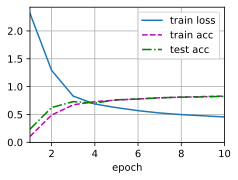

In [14]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [15]:
X = tf.random.uniform((1, 28, 28, 1))
parameters = 0

for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, "Parameters: ",  
          np.sum([np.prod(p.shape) for p in layer.get_weights()]), 
          '\t. Output shape:\t', X.shape)
    parameters += np.sum([np.prod(p.shape) for p in layer.get_weights()])

print("--"*30)
print("Total parameters: ", parameters)


Conv2D Parameters:  156 	. Output shape:	 (1, 28, 28, 6)
AveragePooling2D Parameters:  0.0 	. Output shape:	 (1, 14, 14, 6)
Conv2D Parameters:  2416 	. Output shape:	 (1, 10, 10, 16)
AveragePooling2D Parameters:  0.0 	. Output shape:	 (1, 5, 5, 16)
Flatten Parameters:  0.0 	. Output shape:	 (1, 400)
Dense Parameters:  48120 	. Output shape:	 (1, 120)
Dense Parameters:  10164 	. Output shape:	 (1, 84)
Dense Parameters:  850 	. Output shape:	 (1, 10)
------------------------------------------------------------
Total parameters:  61706.0


## Ejercicios

Resuelve los [ejericios del libro](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html#exercises) con respecto a esta arquitectura y aplicación. Éstos son: 

```{vim}
1. Replace the average pooling with max pooling. What happens?
2. Try to construct a more complex network based on LeNet to improve its accuracy.

    - Adjust the convolution window size.
    - Adjust the number of output channels.
    - Adjust the activation function (e.g., ReLU).
    - Adjust the number of convolution layers.
    - Adjust the number of fully connected layers.
    - Adjust the learning rates and other training details (e.g., initialization and number of epochs.)

3. Try out the improved network on the original MNIST dataset.
4. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).
```
